<h1><center>Abstractive Text Summarizer</center></h1>
<h2><center>Deep Learning Final Project</center></h2>


# Introductory:
#### This source code is split into 3 levels. Firstly, the data processing, in which the data set is loaded, cleaned and split into training and validation data. Secondly, the model creation, in which the Neural Network (encoder-decoder w/ attention), is created, and lastly the validation section in which the model is trained and the results are observed

# Imports

In [1]:
import numpy as np
import pandas as pd
import pickle
from statistics import mode
from statistics import median
import tensorflow as tf

gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

from tensorflow.keras.models import Model
from tensorflow.keras import models
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,Attention
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup as bs
import contractions
import warnings
import nltk
from nltk import word_tokenize
from nltk.stem import LancasterStemmer
from nltk.corpus import stopwords
contraction_list = pickle.load(open("contractions.pkl","rb"))['contractions'] #https://data-flair.training/blogs/machine-learning-text-summarization/
warnings.filterwarnings("ignore")

In [2]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words=set(stopwords.words('english')) 
LStem=LancasterStemmer()
latent_dim = 100

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jepp5\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jepp5\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jepp5\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data Processing

In [3]:
def dataload(Filename=None,amount=100000):
    if Filename is None:
        Filename = "Reviews.csv"
    dataset = pd.read_csv(Filename,nrows=amount)
    dataset.drop_duplicates(subset=['Text'],inplace=True)
    dataset.dropna(axis=0,inplace=True)
    inp_data = dataset.loc[:,'Text']
    inp_data.replace('',np.nan,inplace=True) #If no review, make sure it's NAN, will be discarded later
    target_data = dataset.loc[:,'Summary']
    target_data.replace('',np.nan,inplace=True)
    return inp_data, target_data

def clean_text(text,stem=None):
    cleaned_text = bs(text, "lxml").text 
    cleaned_text = cleaned_text.lower()
    token_words= word_tokenize(cleaned_text) #Split into substrings using nltk.tokenize
    #Convert contraction to it's proper word(s)
    token_words= [contraction_list[x] if x in contraction_list else x for x in token_words] 
    token_words= list(filter(lambda x:(x.isalpha() and len(x)>=3),token_words))
    if stem == "stem":
        token_words= [LStem.stem(w) for w in token_words if w not in stop_words]
    else:
        token_words= [w for w in token_words if w not in stop_words]
    return token_words

In [4]:
#Get 100k rows from Reviews dataset
input_data,target_data = dataload()

input_texts=[] #list of strings
input_words=[] # list of lists of all words
target_texts=[] 
target_words=[]

#TODO: Save the changed data instead of changing it every run
for in_text,tr_text in zip(input_data,target_data):
    #Clean the texts
    in_words= clean_text(in_text,"stem")
    #Returns list, so making it to a string
    input_texts+= [' '.join(in_words)]
    input_words+= in_words
    
    tr_words= clean_text("sos "+tr_text+" eos")
    target_texts+= [' '.join(tr_words)]
    target_words+= tr_words

Percentage of text below 300 0.9784666538491987
Percentage of target below 50:  0.9834654663484919
As such, the max input length is chosen as 300 
and max target length as 11



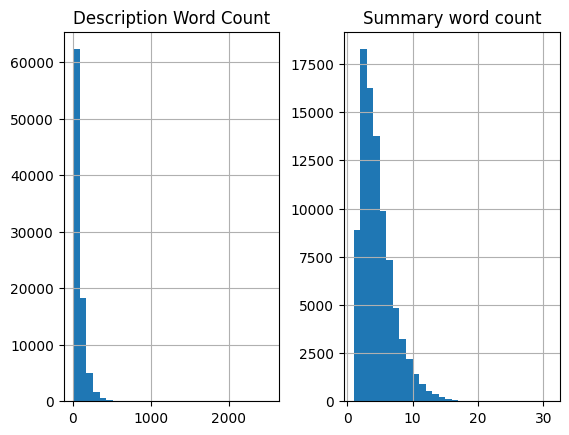

Other data that might be usefull: 

input words amount:  32199
target words amount:  14170
mode of input:  74
mode of target: 17
median of input:  144
median of target:  23
max input size:  7615
max target size:  121


In [5]:

input_words = sorted(list(set(input_words))) #sorted list of all words that occurs in input
target_words = sorted(list(set(target_words))) #sorted list of all words that occurs in target


#Generates some stats, namely length and mode of inp and target
def stats(input_words,input_texts,target_words,target_texts):
    n_inp = len(input_words)
    n_tar = len(target_words)
    mode_inp = mode([len(i) for i in input_texts])
    mode_tar = mode([len(t) for t in target_texts])
    max_inp = max([len(i) for i in input_texts])
    max_tar = max([len(t) for t in target_texts])
    med_inp = median([len(i) for i in input_texts])
    med_tar = median([len(t) for t in target_texts])
    return n_inp,n_tar,mode_inp,mode_tar,max_inp,max_tar,med_inp,med_tar


txt_word_count=[]
summ_word_count=[]
count = 0;
for i in input_data:
    txt_word_count.append(len(i.split()))
    if (len(i.split()) <=300):
        count=count+1;

        
print("Percentage of text below 300",count/len(input_data))

count=0;
for t in target_data:
    summ_word_count.append(len(t.split()))
    if (len(t.split()) <=11):
        count=count+1;
print("Percentage of target below 50: ",count/len(target_data))
print("As such, the max input length is chosen as 300 \nand max target length as 11")
print()
length_df = pd.DataFrame({'Description Word Count':txt_word_count, 'Summary word count':summ_word_count})
length_df.hist(bins=30)

plt.show()
n_inp,n_tar,mode_inp,mode_tar,max_inp,max_tar,med_inp,med_tar = stats(input_words,input_texts,target_words,target_texts)

print("Other data that might be usefull: \n")
print("input words amount: ",n_inp)
print("target words amount: ",n_tar)
print("mode of input: ",mode_inp)
print("mode of target:",mode_tar)
print("median of input: ",med_inp)
print("median of target: ",med_tar)
print("max input size: ",max_inp)
print("max target size: ",max_tar)

max_inp_len = 74 #300
max_tar_len = mode_tar

In [6]:
#We now prepare training data, using default test and trainsize(75-25)
x_train,x_test,y_train,y_test=train_test_split(input_texts,target_texts,random_state=0)

#Utilizing Tokenizer for the words
input_tokenizer = Tokenizer()
input_tokenizer.fit_on_texts(x_train)
train_tokenizer = Tokenizer()
train_tokenizer.fit_on_texts(y_train)
x_train= input_tokenizer.texts_to_sequences(x_train) 
y_train= train_tokenizer.texts_to_sequences(y_train) 

#Dictionary to convert index to word and back
target_w_idx = train_tokenizer.word_index
rev_target_w_idx = train_tokenizer.index_word
rev_inp_w_idx = input_tokenizer.index_word
rev_target_w_idx[0]=' '

In [7]:
#If data less than max size, pad with 0's
enc_in_data= pad_sequences(x_train,  maxlen=max_inp_len, padding='post') 
dec_data= pad_sequences(y_train,  maxlen=max_tar_len, padding='post')

dec_in_data = dec_data[:,:-1] #Dont keep 'sos'
dec_tr_data = dec_data.reshape(len(dec_data),max_tar_len,1)[:,1:] #Dont keep 'eos'

K.clear_session() 

# Model Building


In [8]:
K.clear_session() 
#Creating a 3-stacked LSTM layer using tensorflow
encoder_inputs = Input(shape=(max_inp_len,)) 
encoder_embedding = Embedding(n_inp+1, latent_dim)(encoder_inputs) 

layer1= LSTM(latent_dim, return_state=True, return_sequences=True) 
layer2= LSTM(latent_dim, return_state=True, return_sequences=True) 
layer3= LSTM(latent_dim, return_sequences=True, return_state=True)
output_layer1, hidden_layer1, cell_layer1= layer1(encoder_embedding) 
output_layer2, hidden_layer2, cell_layer2= layer2(output_layer1) 
output_layer3, hidden_layer3, cell_layer3= layer3(output_layer2)

encoder_states= [hidden_layer3, cell_layer3]


In [9]:
#Creating the Decoder, similarly to the Encoder
decoder_inputs = Input(shape=(None,)) 
decoder_embedded_layer = Embedding(n_tar+1, latent_dim) 
decoder_embedding = decoder_embedded_layer(decoder_inputs) 

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, *_ = decoder_lstm(decoder_embedding,initial_state=encoder_states) #use encoder states as initial

#Attention layer
attention =Attention()
attention_output = attention([decoder_outputs,output_layer3])

combined1=Concatenate(axis=-1, name='layer1_concat')([decoder_outputs,attention_output])

In [10]:
#Output layer (Dense)
decoder_dense = Dense(n_tar+1, activation='softmax') 
decoder_outputs = decoder_dense(combined1) 

#Show model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
#model = models.load_model("0612model")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 74)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 74, 100)      3220000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 74, 100),    80400       ['embedding[0][0]']              
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                              

In [24]:

es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=3)
model.compile( 
    optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"] ) 

history = model.fit( #64 batch size was chosen due to ram limitations on my gpu
    [enc_in_data, dec_in_data],
    dec_tr_data, 
    batch_size=128,
    callbacks=[es],
    epochs=20, 
    validation_split=0.1,
    )

Epoch 1/20
467/467 [==============================] - 49s 90ms/step - loss: 0.9197 - accuracy: 0.8575 - val_loss: 1.1684 - val_accuracy: 0.8402
Epoch 2/20
467/467 [==============================] - 40s 86ms/step - loss: 0.9091 - accuracy: 0.8586 - val_loss: 1.1724 - val_accuracy: 0.8392
Epoch 3/20
467/467 [==============================] - 40s 85ms/step - loss: 0.9004 - accuracy: 0.8595 - val_loss: 1.1777 - val_accuracy: 0.8379
Epoch 4/20
467/467 [==============================] - 40s 86ms/step - loss: 0.8927 - accuracy: 0.8607 - val_loss: 1.1829 - val_accuracy: 0.8389
Epoch 4: early stopping


In [18]:
#model.save('0612model')
#model = models.load_model("testmodel_3")

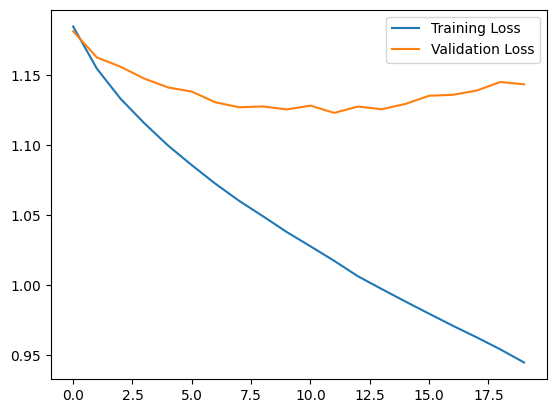

In [14]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'],label='Training Loss')
pyplot.plot(history.history['val_loss'],label='Validation Loss')
pyplot.legend()
pyplot.show()

In [15]:
#Make encoder & decoder model similarly to earlier, however draw from model
#Encoder:
encoder_outputs,encoder_hidden,encoder_cell = model.layers[6].output
encoder_states=[encoder_hidden,encoder_cell]
encoder_model = Model(model.input[0],[encoder_outputs]+encoder_states)

#Decoder:
decoder_hidden_state = Input(shape=(latent_dim,))
decoder_cell_state = Input(shape=(latent_dim,))
decoder_input_hidden = Input(shape=(max_inp_len,latent_dim))

decoder_inputs = model.input[1]
decoder_embedded_layer = model.layers[5]
decoder_lstm = model.layers[7]

decoder_embedding= decoder_embedded_layer(decoder_inputs)
decoder_outputs2, hidden_layer2,cell_layer2 = decoder_lstm(decoder_embedding, initial_state=[decoder_hidden_state,decoder_cell_state])



In [16]:

#Attention:
attention = model.layers[8]
attention_output2 = attention([decoder_outputs2,decoder_input_hidden])

#merge together
conc_layers2 = Concatenate(axis=-1)([decoder_outputs2, attention_output2]),

#Output layer:
decoder_dense = model.layers[10]
decoder_outputs2 = decoder_dense(conc_layers2[0])

#Create decoder model, same as encoder model earlier
decoder_model = Model([decoder_inputs] + [decoder_input_hidden,decoder_hidden_state,decoder_cell_state],
[decoder_outputs2] + [hidden_layer2, cell_layer2])

In [56]:
def generate_summary(integer_sequence):
    stop = False #stop_condition
    summary = "" #decoded_sentence
    target_sequence = np.zeros((1,1))
    target_sequence[0,0] = target_w_idx['sos']
    encoder_out,encoder_hidden,encoder_cell = encoder_model.predict(integer_sequence)
    while not stop:
        output_words, decoder_hidden,decoder_cell = decoder_model.predict([target_sequence]+
                                                                          [encoder_out,
                                                                           encoder_hidden,
                                                                           encoder_cell])
        word_idx = np.argmax(output_words[0,-1,:])
        text_word= rev_target_w_idx[word_idx]
        if text_word == "eos" or len(summary) > max_tar_len:
            stop = True
            break
        summary = summary + text_word + " "

        target_sequence = np.zeros((1,1))
        target_sequence[0,0] = word_idx
        encoder_hidden,encoder_cell = decoder_hidden,decoder_cell
    return summary

In [57]:
inp_review = input("Enter : ")
print("Review :",inp_review)

inp_review = clean_text(inp_review,"stem")
inp_review = ' '.join(inp_review)
inp_x= input_tokenizer.texts_to_sequences([inp_review]) 
inp_x= pad_sequences(inp_x,  maxlen=max_inp_len, padding='post')

summary=decode_sequence(inp_x.reshape(1,max_inp_len))
if 'eos' in summary :
  summary=summary.replace('eos','')
print("\nPredicted summary:",summary);print("\n")

Enter : d
Review : d
1/1 [==============================] - 0s 25ms/step

Predicted summary: great  




In [58]:
def seq2text(seq):
    text = ""
    for i in seq:
        if(i!=0):
            text=text+rev_inp_w_idx[i]+" "
    return text
def seq2sum(seq):
    summ = ""
    for i in seq:
        if ((i!=0 and i!=target_w_idx['sos']) and i!=target_w_idx['eos']):
            summ = summ+rev_target_w_idx[i]+" "
    return summ

for i in range(15):
    if len(x_train[i])<=max_inp_len:
        print("Review:",(seq2text(x_train[i])))
        print("\n")
        print("Original Summ:",seq2sum(y_train[i]))
        print("\n")
        #x = pad_sequences(x_train[i],  maxlen=max_inp_len, padding='post')
        #print(x_train[i])
        #print(enc_in_data[i])
        print("Predicted Summ:",generate_summary(enc_in_data[i].reshape(1,max_inp_len)))
        print("\n")

Review: box smash pack box bar crumb ed messy 


Original Summ: smashed still edible 


1/1 [==============================] - 0s 31ms/step
Predicted Summ: wrong product 


Review: lov classs cer ad fresh fruit non fat yogurt delicy wish cam larg pack siz 


Original Summ: great 


1/1 [==============================] - 0s 29ms/step
Predicted Summ: great 


Review: mallom cooky pretty yummy slight spicy cooky bas fluffy marshmallow top cov dark chocol nev gre fan smor gav cooky on son friend said tast lik smor although keen tast fan dark chocol complaint reason star entir cont pack ar clear pack provid amazon protect transit insufficy rig high recommend cooky 


Original Summ: yummy 


1/1 [==============================] - 0s 32ms/step
Predicted Summ: great taste 


Review: right bat know switch tradit sod ad sug corn syrup preserv carbon nat juic juic vitamin way stil poppy bit try enjoy kiw berry watermelon strawberry flav good dec pastry black cherry diff cas first smel lik grap pe